# Lake Whakatipu samples only

In [1]:
import sys
print(sys.version)
!python --version

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0]
Python 3.11.3


In [2]:
#imports
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from pathlib import Path

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

print ("Completed")

Completed


In [3]:
# all south island samples
data_path = Path("/nesi/nobackup/uoo03627/qt_rat_sequencing/RRATTUS_ALL_SI/results/09_genotyped_GATK/plinkpca/lakewhakatipu")
prefix = "allvariants_gatk_dp_m05_pca_LS_subsample1_10k_sorted"

In [4]:
# Next we read the plink formatted genotype data and impute any missing SNPs with the mean at each SNP: (thiis is in their pipeline so try this first)

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink(str(data_path / prefix))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))
print("Done")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 114.52it/s]


n_samples=31, n_snps=10000
Done


In [5]:
%%time
# setup graph
feems_path = "/nesi/nobackup/uoo03627/qt_rat_sequencing/feems/LakeWhakatipushapefiles"

print("reading coords")
coord = np.loadtxt("{}/rats_coords_LW_nonames.txt".format(feems_path))  # sample coordinates, no names, in order they are in the vcf
print("reading poly")
outer = np.loadtxt("{}/LW_polygon.outer".format(feems_path))  # outer coordinates
print("reading shp")
grid_path = "{}/LW_triangular_grid_0.05.shp".format(feems_path)  # path to discrete global grid, WGS84

reading coords
reading poly
reading shp
CPU times: user 1.24 ms, sys: 1.21 ms, total: 2.44 ms
Wall time: 2.66 ms


In [6]:
%%time
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                          ggrid=grid_path,
                                          translated=False, 
                                          buffer=0,
                                          outer=outer)

print("Done")

Done
CPU times: user 968 ms, sys: 12.2 ms, total: 981 ms
Wall time: 1.02 s


# graphs


In [11]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

CPU times: user 42.9 s, sys: 29 ms, total: 43 s
Wall time: 43.1 s


/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/feems/spatial_graph.py:81: RuntimeWarning: divide by zero encountered in true_divide
  self.frequencies = self.frequencies / np.sqrt(self.mu * (1 - self.mu))


In [12]:
# projection from cartopy's coordinate reference system (ccrs) module, centered in the middle of the south island of nz near Peel Forest, -43.644076, 170.786516
projection = ccrs.Orthographic(central_longitude=170.786516, central_latitude=-43.644076)

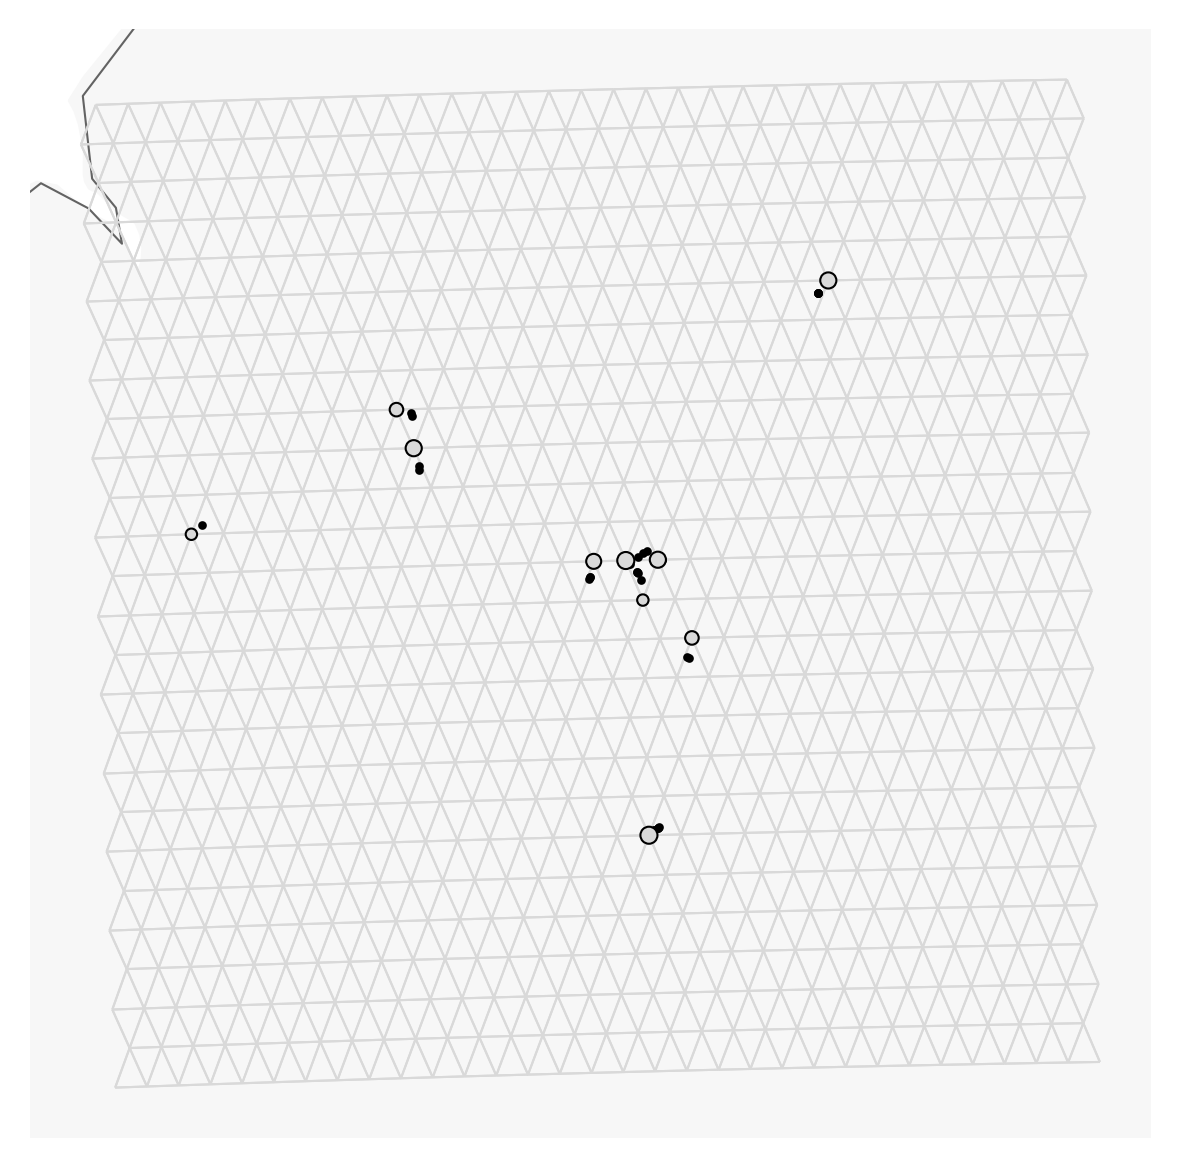

In [13]:
# we first of all visualise the graph and sample locations. The black points are the observed locations for each sample and the grey points show the nodes theyy were assigned to. 
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [14]:
# fit feems
# large lambda (regularization/smoothing parameter)
sp_graph.fit(lamb = 20.0)

/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/feems/objective.py:165: RuntimeWarning: invalid value encountered in matmul
  self.trA = self.sp_graph.S @ self.inv_cov
/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/feems/objective.py:165: RuntimeWarning: invalid value encountered in matmul
  self.trA = self.sp_graph.S @ self.inv_cov
/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/feems/objective.py:165: RuntimeWarning: invalid value encountered in matmul
  self.trA = self.sp_graph.S @ self.inv_cov
/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib/python3.8/site-packages/feems/objective.py:165: RuntimeWarning: invalid value encountered in matmul
  self.trA = self.sp_graph.S @ self.inv_cov
/scale_wlg_nobackup/filesets/nobackup/uoo03627/qt_rat_sequencing/feems/feems_env/lib

AssertionError: did not converge

In [ ]:
# visualise the weighted graph
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar(location='right')